In [1]:
import sys
sys.path.append('./cs16')
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
from keras.callbacks import EarlyStopping
from keras.layers import (Activation, Attention, Bidirectional, Concatenate, Conv1D,
                           Dense, Dropout, Embedding, Flatten, GlobalMaxPooling1D,
                           Input, Layer, LSTM, MaxPooling1D, Multiply, Permute,
                           RepeatVector, Reshape, SpatialDropout1D, TimeDistributed)
from keras.models import Model
from keras import backend as K
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
import cs16.prep as prep16
import cs16.plot as plot16
import cs16.build as build16
imagesize = 64

import pandas as pd

data_type = input("Enter '1. single' for single dataset or '2. multi' for multiple dataset: ")

if data_type == '1':
    file_path = 'single.txt'
    folder_path = './data/MVSA/single/'
elif data_type == '2':
    file_path = 'multi.txt'
    folder_path = './data/MVSA/multiple/'
else:
    print("Invalid input. Please enter either 'single' or 'multi'.")
    exit()

df = pd.read_csv(file_path, index_col=None, encoding='ISO-8859-1')


Enter '1. single' for single dataset or '2. multi' for multiple dataset: 2


In [2]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import pandas as pd
import matplotlib.pyplot as plt
# Download stopwords and punkt tokenizer if not already downloaded
nltk.download('stopwords')
nltk.download('punkt')

# Define a function to preprocess text
def nlp_text(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove URLs using regex
    text = re.sub(r'http\S+', '', text)
    
    # Remove punctuation using regex
    text = re.sub(r'[^\w\s]', '', text)
    
    # Tokenize text into individual words
    words = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    # Stem words using Porter Stemmer
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    
    # Join words back into a single string
    text = ' '.join(words)
    
    return text

# Apply the preprocess_text function to the 'tweet' column of the dataframe
df['tweet'] = df['tweet'].apply(nlp_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ausco\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ausco\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
X_text, y_text = prep16.preprocess_text(df)
X_train_text, X_val_text, X_test_text, \
y_train_text, y_val_text, y_test_text = prep16.split_data(X_text, y_text, random_state=42)

X_polar, y_polar = prep16.preprocess_text(df,label = 'polarity')
X_train_polar, X_val_polar, X_test_polar, \
y_train_polar, y_val_polar, y_test_polar = prep16.split_data(X_polar, y_polar, random_state=42)

image_data_s, image_label_s = prep16.preprocess_images(df, folder_path, imagesize)
y_s = to_categorical(image_label_s, num_classes=3)

X_train_image, X_val_image, X_test_image, \
y_train_image, y_val_image, y_test_image= prep16.split_data(image_data_s, y_s, random_state=42)

y_train = to_categorical(y_train_polar, num_classes=3)
y_val =to_categorical(y_val_polar, num_classes=3)
y_test =to_categorical(y_test_polar, num_classes=3)
print(file_path)

multi.txt


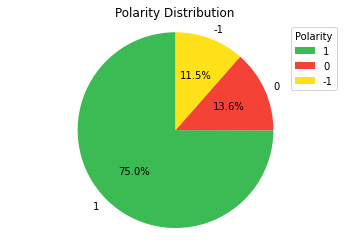

In [91]:
import pandas as pd
import matplotlib.pyplot as plt
# distribution of polarity
polarity_counts =df['polarity'].value_counts(normalize=True)

# assign colors for each category
colors = ['#3cba54', '#f44336', '#ffe119']

# Create a pie chart of the polarity distribution
plt.pie(polarity_counts.values, labels=polarity_counts.index, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Polarity Distribution')
plt.legend(title='Polarity', loc='best')
plt.show()

# TEXT

In [87]:
textclassifier ='BiLSTM + ATT'

class ContentAttention(Layer):
    def __init__(self, **kwargs):
        super(ContentAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super(ContentAttention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)    
    
from keras import regularizers
from keras.layers import Bidirectional, LSTM, Concatenate, Reshape

text_input = Input(shape=(X_train_text.shape[1],), dtype='int32', name='text_input')
embedding_layer = Embedding(input_dim=10000, output_dim=100, input_length=X_train_text.shape[1])(text_input)

lstm1 = Bidirectional(LSTM(128, return_sequences=True))(embedding_layer)
att_layer1 = ContentAttention()(lstm1)
sent_representation1 = att_layer1

lstm2 = Bidirectional(LSTM(128, return_sequences=True))(embedding_layer)
att_layer2 = ContentAttention()(lstm2)
sent_representation2 = att_layer2

#----------local fusion---------------
merged_layer = Concatenate()([sent_representation1, sent_representation2]) 

t = Dense(128, activation='tanh')(merged_layer)
t = Reshape((1, 128))(t)  
t = Bidirectional(LSTM(64))(t)
text_output = Dense(3, activation='tanh', kernel_regularizer=regularizers.l2(0.01))(t)


print(textclassifier)


BiLSTM + ATT


# Image

In [127]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Concatenate, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization

imageclassifier = 'VGG + CNN + Spatial Attention'

# Load pre-trained VGG16 model
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(imagesize, imagesize, 3))

# Freeze the weights of the VGG16 layers
for layer in vgg16_base.layers:
    layer.trainable = False

# ------------ CNN --------------------------
image_input = Input(shape=(imagesize, imagesize, 3), name='image_input')
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(image_input)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
pool1 = Dropout(0.25)(pool1)
#pool1 = BatchNormalization()(pool1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
pool2 = Dropout(0.25)(pool2)
#pool2 = BatchNormalization()(pool2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
pool3 = Dropout(0.25)(pool3)
#pool3 = BatchNormalization()(pool3)

conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
pool4 = Dropout(0.25)(pool4)
#pool4 = BatchNormalization()(pool4)

# Add spatial attention to CNN features
cnn_attention = Conv2D(1, (1, 1), activation='sigmoid')(pool4)
attended_features = Multiply()([pool4, cnn_attention])

cnn_flatten = Flatten()(attended_features)

#--------------VGG--------------------------------
vgg16_features = vgg16_base(image_input)

# Add spatial attention to VGG16 features
attention = Conv2D(1, (1, 1), activation='sigmoid')(vgg16_features)
attended_features = Multiply()([vgg16_features, attention])

# Flatten the attended features
vgg_flatten = Flatten()(attended_features)

#----------local fusion---------------
merged_features = Concatenate()([cnn_flatten, vgg_flatten])

# Apply the rest of the model layers
merged = Dense(512, activation='relu')(merged_features)
merged = Dropout(0.5)(merged)
image_output = Dense(3, activation='relu', kernel_regularizer=regularizers.l2(0.05))(merged)

print(imageclassifier)


VGG + CNN + Spatial Attention


# Fusion

In [128]:
from keras.optimizers import Adam, Adagrad, RMSprop
from keras import backend as K
from keras import metrics

#----------Global fusion---------------
concatenated = Concatenate()([text_output, image_output])
# Final output layers
output = Dense(3, activation='softmax')(concatenated)
model = Model(inputs=[text_input, image_input], outputs=output)
print(file_path)

# Compile the model
optimizer = Adam(learning_rate=1e-3)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model
history = model.fit([X_train_text, X_train_image], y_train, 
                    validation_data=([X_val_text, X_val_image], y_val),
                    epochs=3, 
                    batch_size=64)

# Evaluate the model
test_loss, test_acc = model.evaluate([X_test_text, X_test_image], y_test)
print('Test accuracy:', test_acc)


multi.txt
Epoch 1/3
244/244 [==============================] - 920s 4s/step - loss: 0.7739 - accuracy: 0.7429 - val_loss: 0.6875 - val_accuracy: 0.7704
Epoch 2/3
244/244 [==============================] - 924s 4s/step - loss: 0.6077 - accuracy: 0.7527 - val_loss: 0.6963 - val_accuracy: 0.7668
Epoch 3/3
61/61 [==============================] - 52s 847ms/step - loss: 0.7492 - accuracy: 0.7107
Test accuracy: 0.710688591003418


# Metrics

In [8]:
from sklearn.metrics import classification_report
import numpy as np

# Make predictions on test data
y_pred = model.predict([X_test_text, X_test_image])

# Convert predictions and true labels to class indices
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate classification report
report = classification_report(y_true_classes, y_pred_classes, digits = 4)
print(f"image:{imageclassifier}, Text:{textclassifier}")
# Print the report
print('Classification Report:\n', report)


61/61 [==============================] - 23s 348ms/step
image:VGG + CNN + Spatial Attention, Text:BiLSTM + content att
Classification Report:
               precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       254
           1     0.7807    0.9452    0.8551      1461
           2     0.3672    0.2814    0.3186       231

    accuracy                         0.7431      1946
   macro avg     0.3826    0.4089    0.3912      1946
weighted avg     0.6297    0.7431    0.6798      1946



C:\Users\ausco\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ausco\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ausco\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# LATE FUSION

In [129]:
#----------------image----------------
image_feature_extractor = Model(inputs=image_input, outputs=image_output)

val_image_features = image_feature_extractor.predict(X_val_image)
test_image_features = image_feature_extractor.predict(X_test_image)

#--------------text----------------
text_feature_extractor = Model(inputs=text_input, outputs=text_output)

val_text_features = text_feature_extractor.predict(X_val_text)
test_text_features = text_feature_extractor.predict(X_test_text)

#---------------combine----------------

val_features = np.concatenate([val_image_features, val_text_features], axis=1)
test_features = np.concatenate([test_image_features, test_text_features], axis=1)

# one-hot encoded vectors if needed
y_val_labels = y_val_polar #np.argmax(y_val_image, axis=1)
y_test_labels = y_test_polar#np.argmax(y_test_image, axis=1)


61/61 [==============================] - 17s 276ms/step


## XGB

In [119]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

# Encode the target variable
label_encoder = LabelEncoder()
y_val_labels_encoded = label_encoder.fit_transform(y_val_labels)
y_test_labels_encoded = label_encoder.transform(y_test_labels)

xgb_model = xgb.XGBClassifier(n_estimators=90, max_depth=3) #reg_lambda reg_alpha

# Train the XGBoost model
xgb_model.fit(val_features, y_val_labels_encoded)

# Evaluate the model
xgb_score = xgb_model.score(test_features, y_test_labels_encoded)
print("Late Fusion Test Accuracy: {:.2f}%".format(xgb_score * 100))

y_pred = xgb_model.predict(test_features)

# Print classification report
print(classification_report(y_test_labels_encoded, y_pred, digits=4))

Late Fusion Test Accuracy: 74.00%
              precision    recall  f1-score   support

           0     0.2949    0.0996    0.1489       231
           1     0.2353    0.0157    0.0295       254
           2     0.7634    0.9671    0.8533      1461

    accuracy                         0.7400      1946
   macro avg     0.4312    0.3608    0.3439      1946
weighted avg     0.6388    0.7400    0.6621      1946



## Random Forest

In [65]:
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier

rf = RandomForestClassifier(n_estimators=100, max_depth=5)

rf.fit(val_features, y_val_labels)
rf_score = rf.score(test_features, y_test_labels)
print("Late Fusion Test Accuracy: {:.2f}%".format(rf_score * 100))
#from sklearn.metrics import classification_report

# Predict labels for test data
y_pred = rf.predict(test_features)

# Print classification report
print(classification_report(y_test_labels, y_pred, digits=4))

Late Fusion Test Accuracy: 75.28%
              precision    recall  f1-score   support

          -1     0.4118    0.0909    0.1489       231
           0     0.0000    0.0000    0.0000       254
           1     0.7632    0.9884    0.8613      1461

    accuracy                         0.7528      1946
   macro avg     0.3917    0.3598    0.3368      1946
weighted avg     0.6219    0.7528    0.6643      1946



## MLP

In [90]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

# Create an MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(256, 128), 
                    activation='relu', solver='lbfgs', learning_rate = 'invscaling')

# Fit the classifier to the training data
mlp.fit(val_features, y_val_labels)

# Evaluate the classifier on the test data
mlp_score = mlp.score(test_features, y_test_labels)
print("Late Fusion Test Accuracy: {:.2f}%".format(mlp_score * 100))

# Predict labels for the test data
y_pred = mlp.predict(test_features)

# Print classification report
print(classification_report(y_test_labels, y_pred, digits=4))

Late Fusion Test Accuracy: 75.28%
              precision    recall  f1-score   support

          -1     0.4286    0.0909    0.1500       231
           0     0.0000    0.0000    0.0000       254
           1     0.7612    0.9884    0.8600      1461

    accuracy                         0.7528      1946
   macro avg     0.3966    0.3598    0.3367      1946
weighted avg     0.6224    0.7528    0.6635      1946



C:\Users\ausco\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ausco\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ausco\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


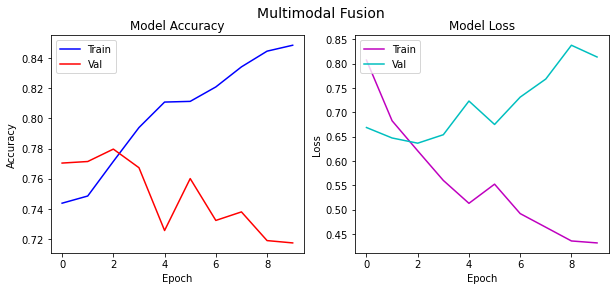

In [89]:
plot16.plot_hist(history, 'Multimodal Fusion')